# Learning objective

This notebook illustrates how initial conditions evolve under different wave-related PDEs. In doing so, it is shown how different terms (linear vs. nonlinear advection and dissipation vs. dispersion) in such a PDE affect the shape evolution of wave profile.

# Preliminaries

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25,
          'animation.embed_limit': 2**128}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy import fft
from scipy.interpolate import griddata

# to save plots as files and download them
#from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

# Setup common to all equations

In all cases, we restrict themselves to the spatial interval $0 \le x < x_\mathrm{max} = 2$ with
*   either periodic boundary conditions, $u(0,t)=u(x_\mathrm{max},t)$ for every $t\ge0$,
*   or homogeneous Neumann boundary conditions, $\partial u/\partial x = 0$ at $x=0,x_\mathrm{max}$ for every $t\ge0$.



In [2]:
# dispersion parameter for KdV-like u_xxx term, keep it small
delta = 0.022

# wave speed for linear wave eqs.
cw = 1

# spatial interval
xmax = 2
# number of grid points in discretization
N = 200
# grid spacing
h = (xmax-0)/N

# the grid
# for periodic BC, we *must* exclude xmax (endpoint=False)
# for Neumann BCs, we don't have to exclude xmax, but it's easier to do it the same way
xj = np.linspace(0,xmax,num=N,endpoint=False)

# maximum integration time is up to you
# for my examples I make multiple of T_B=1/pi (see ZK65), why not?
TB = 1/np.pi
tmax = 10*TB

# try: test different tolerances for the integrator, changing reltol
reltol = 1e-6

# the type of BC to implement in the numerics will be specified for each initial condition,
# only 'Neumann' and 'periodic' allowed right now
bc_type = ''

# The initial and boundary conditions

**Choice 1a**, the ZK65 cosine:
$$ u(x,0) = \cos(\pi x). $$

In [3]:
uic = np.cos(np.pi*xj)

bc_type = 'periodic'

**Choice 1b**, two periods of a sine:
$$ u(x,0) = \sin(2\pi x). $$

In [4]:
uic = np.sin(2*np.pi*xj)

bc_type = 'periodic'

**Choice 2**, a Gaussian pulse:
$$ u(x,0) = e^{-3\pi (x-1)^2}. $$

In [5]:
uic = np.exp(-((xj-1)*3*np.pi)**2)

bc_type = 'periodic'

**Choice 3**, multiple wave numbers:
$$ u(x,0) = \cos(\pi x) + \sin(4\pi x). $$

In [6]:
uic = np.cos(np.pi*xj) + np.sin(np.pi*xj*4)

bc_type = 'periodic'

**Choice 4**, a kink-shaped 'diffusive soliton' (see Remoissenet, Sect. 11.1.3 with some change in notation):
$$ u(x,0) = \frac{u_+ + u_-}{2} + \frac{u_+ - u_-}{2} \tanh\left(\frac{|u_+ - u_-|}{4\delta}(x-1)\right)$$

**Note**: this IC is not periodic, so its best to use "[Neumann BCs](https://en.wikipedia.org/wiki/Neumann_boundary_condition)", and most easily implemented as $u_{-1}=u_1$ and $u_{N}=u_{N-2}$). However, there's subtetlies about the stable implmentation of BCs, and also their physical meaning/effects, which are different for _each_ these equations. So, I would advise you to consider only time intervals over which the dynamics do not "reach" the boundaries, which can be achieved by taking shorter `tmax` or larger `xmax`.

In [7]:
up, um = -0.5, 1
uic = (up+um)/2 + (up-um)/2 * np.tanh((xj-1)*np.abs(up-um)/4/delta)

bc_type = 'Neumann'

Whichever initial condition we chose, let's plot it.

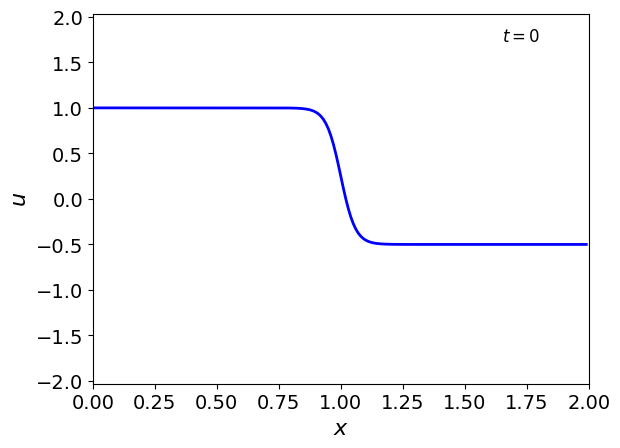

In [8]:
fig, ax = plt.subplots()
ax.plot(xj, uic, color='blue', linewidth=2)
ax.set_ylim(-2.03,2.03) # a common set of ylim that works for all examples
ax.set_ylabel('$u$')
ax.set_xlim(0,xmax)
ax.set_xlabel('$x$')
ttl = ax.text(0.825, 0.925, '$t=0$', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True);

# PDE\#1: One-way wave equation

First example of wave profile evolution will be under the _one-way_ (first-order) linear wave equation:
$$ u_t + c u_x = 0. $$

Using the [method of lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html), we turn the PDE into a series of ODEs:
$$
  \dot{u}_j = -c\underbrace{\left(\frac{u_{j+1} - u_{j-1}}{2h}\right)}_{\approx u_x} ,\quad j=1,\dots,N-2.
$$

Here, $u_j(t) \approx u(x_j,t)$ and $x_j = 0+jh$ with $h=(x_\mathrm{max}-0)/N$ being the grid spacing. For periodic BCs, $u_0=u_{N-1}$ are the _same_ gridpoint, in which case $j=N-1$ is not included because. For other BCs, special care is taken at $j=0$ and $j=N-1$.

In [9]:
# ODE system right-hand side
def onewaywave(t,u):
  F = np.empty(N)

  # boundary nodes require special care to enforce BCs
  if bc_type == 'periodic':
    F[0] = -cw*(u[1] - u[N-1])/(2*h)
    F[N-1] = -cw*(u[0] - u[N-2])/(2*h)
  elif bc_type == 'Neumann':
    F[0] = 0
    # Neumann-ish to impose outgoing wave
    # by backwards difference at the last grid point
    F[N-1] = -cw*(u[N-1] - u[N-2])/h
  else:
    raise ValueError('Unknown BC type!')

  # interior nodes, per the formula
  for j in range(1,N-1):
    F[j] = -cw*(u[j+1] - u[j-1])/(2*h)

  return F

In [10]:
# simulate the PDE
sol1 = solve_ivp(fun=onewaywave,
                 t_span=[0,tmax], y0=uic,
                 method='RK45', rtol=reltol, dense_output=True)

## Plotting and dynamics

Next, we visualize our results using our snazzy animation tools.

In [11]:
# can change the plotting range for the animation if you wish
tplot = tmax
# define how to sample the solution in time
tnum = 100
dt = (tplot-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u$')
ax.set_xlabel('$x$')
ax.set_xlim(0,xmax)
ax.set_ylim(-2.03,2.03)
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(xj, 0*xj, color='blue', linewidth=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol1.sol(it*dt)
  line.set_data(xj, uj)
  ttl.set_text(f'$t={it*dt:.3f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

# PDE\#2: Two-way wave equation

Second example of wave profile evolution will be under the _two-way_ (second-order) linear wave equation:
$$ u_{tt} - c^2 u_{xx} = 0. $$
As with the mass-and-spring chain, we will have to write the second-order-in-time PDE as an equivalent first-order _system_:
$$
  \left\{ \begin{align} u_{t} &= v,\\ v_t &= c^2 u_{xx}, \end{align} \right.
$$
which we discretize as usual by the method of lines:
$$
  \left\{ \begin{align} \dot{u}_j &= v_j,\\ \dot{v}_j &= \underbrace{\left(\frac{u_{j+1} - 2u_j + u_{j-1}}{h^2}\right)}_{\approx u_{xx}} - u_j. \end{align} \right.
$$


In [12]:
# ODE system right-hand side
def twowaywave(t,u):
  F = np.empty(2*N)

  # boundary nodes require special care to enforce BCs
  if bc_type == 'periodic':
    F[0] = u[N]
    F[N-1] = u[2*N-1]
    F[N] = cw**2 * (u[1] - 2*u[0] + u[N-1])/h**2
    F[2*N-1] = cw**2 * (u[0] - 2*u[N-1] + u[N-2])/h**2
  elif bc_type == 'Neumann':
    F[0] = 0
    F[N-1] = 0
    F[N] = cw**2 * (u[1] - 2*u[0] + u[1])/h**2
    F[2*N-1] = cw**2 * (u[N-2] - 2*u[N-1] + u[N-2])/h**2
  else:
    raise ValueError('Unknown BC type!')

  # interior nodes, per the ODE formula
  for j in range(1,N-1):
    F[j]   = u[j+N]
    F[j+N] = cw**2 * (u[j+1] - 2*u[j] + u[j-1])/h**2

  return F

In [13]:
# add second IC of zero velocity for this PDE
uvic = np.concatenate((uic,np.zeros(len(uic))))

In [14]:
# simulate the PDE
sol2 = solve_ivp(fun=twowaywave,
                 t_span=[0,tmax], y0=uvic,
                 method='RK45', rtol=reltol, dense_output=True)

## Plotting and dynamics

In [15]:
# can change the plotting range for the animation if you wish
tplot = tmax
# define how to sample the solution in time
tnum = 100
dt = (tplot-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u$')
ax.set_xlabel('$x$')
ax.set_xlim(0,xmax)
ax.set_ylim(-2.03,2.03)
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(xj, 0*xj, color='blue', linewidth=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol2.sol(it*dt)[0:N]
  line.set_data(xj, uj)
  ttl.set_text(f'$t={it*dt:.3f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

# PDE#3: One-way wave equation with dispersion

Third example of wave profile evolution will be under the one-way linear wave equation _with dispersion_ (linerized KdV in the stationary frame):
$$
  u_t + c u_x + \delta^2 u_{xxx} = 0,
$$
which we discretize by the method of lines as:
$$
  \dot{u}_j = -c\underbrace{\left(\frac{u_{j+1} - u_{j-1}}{2h}\right)}_{\approx u_x} - \delta^2\underbrace{\left(\frac{u_{j+2} - 2u_{j+1} + 2u_{j-1} - u_{j-2}}{2h^3}\right)}_{\approx u_{xxx}}.
$$

In [16]:
# ODE system right-hand side
def onewaydispwave(t,u):
  F = np.empty(N)

  # boundary nodes require special care to enforce BCs
  if bc_type == 'periodic':
    F[0] = -cw * (u[1] - u[N-1])/(2*h) \
          -delta**2*(u[2] - 2*u[1] + 2*u[N-1] - u[N-2])/(2*h**3)
    F[1] = -cw * (u[2] - u[0])/(2*h) \
          -delta**2*(u[3] - 2*u[2] + 2*u[0] - u[N-1])/(2*h**3)
    F[N-2] = -cw * (u[N-1] - u[N-3])/(2*h) \
              -delta**2*(u[0] - 2*u[N-1] + 2*u[N-3] - u[N-4])/(2*h**3)
    F[N-1] = -cw * (u[0] - u[N-2])/(2*h) \
              -delta**2*(u[1] - 2*u[0] + 2*u[N-2] - u[N-3])/(2*h**3)
  elif bc_type == 'Neumann':
    F[0] = 0
    F[1] = 0
    F[N-2] = 0
    F[N-1] = 0
  else:
    raise ValueError('Unknown BC type!')

  # interior nodes, per the formula
  for j in range(2,N-2):
    F[j] = -cw * (u[j+1] - u[j-1])/(2*h) \
           -delta**2*(u[j+2] - 2*u[j+1] + 2*u[j-1] - u[j-2])/(2*h**3)

  return F

In [17]:
# simulate the PDE
sol3 = solve_ivp(fun=onewaydispwave,
                 t_span=[0,tmax], y0=uic,
                 method='Radau', rtol=reltol, dense_output=True)

## Plotting and dynamics

In [18]:
# can change the plotting range for the animation if you wish
tplot = tmax
# define how to sample the solution in time
tnum = 100
dt = (tplot-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u$')
ax.set_xlabel('$x$')
ax.set_xlim(0,xmax)
ax.set_ylim(-2.03,2.03)
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(xj, 0*xj, color='blue', linewidth=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol3.sol(it*dt)
  line.set_data(xj, uj)
  ttl.set_text(f'$t={it*dt:.3f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

# PDE\#4: One-way nonlinear wave equation

Fourth example of wave profile evolution will be under a one-way _nonlinear_ wave equation:
$$ u_t + u u_x = 0. $$
The key point is that now $c=u$ (_not a constant_) leading to the nonlinear product $uu_x$ in the PDE. This simple-looking PDE is called the [_inviscid Burgers equation_](https://en.wikipedia.org/wiki/Burgers%27_equation).

We discretize this PDE by the method of lines as:
$$
  \dot{u}_j = -u_j\underbrace{\left(\frac{u_{j+1} - u_{j-1}}{2h}\right)}_{\approx u_x}.
$$

In [19]:
# ODE system right-hand side
def iburgers(t,u):
  F = np.empty(N)

  # boundary nodes require special care to enforce BCs
  if bc_type == 'periodic':
    F[0] = -u[0] * (u[1] - u[N-1])/(2*h)
    F[N-1] = -u[N-1] * (u[0] - u[N-2])/(2*h)
  elif bc_type == 'Neumann':
    F[0] = 0
    F[N-1] = 0
  else:
    raise ValueError('Unknown BC type!')

  # interior nodes, per the formula
  for j in range(1,N-1):
    F[j] = - u[j] * (u[j+1] - u[j-1])/(2*h)
    #       + 0.1*h * (u[j+1] - 2*u[j] + u[j-1])/h**2
    # you could try to add some 'fake' diffusion ~ h, to stabilize the scheme

  return F

In [20]:
# simulate the PDE
sol4 = solve_ivp(fun=iburgers,
                 t_span=[0,tmax], y0=uic,
                 method='RK45', rtol=reltol, dense_output=True)

## Plotting and dynamics

In [21]:
# can change the plotting range for the animation if you wish
tplot = 1.1*TB
# define how to sample the solution in time
tnum = 100
dt = (tplot-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u$')
ax.set_xlabel('$x$')
ax.set_xlim(0,xmax)
ax.set_ylim(-2.03,2.03)
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(xj, 0*xj, color='blue', linewidth=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol4.sol(it*dt)
  line.set_data(xj, uj)
  ttl.set_text(f'$t={it*dt:.3f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

# PDE\#5: One-way nonlinear wave equation with dissipation

Fifth example of wave profile evolution will be under a one-way _nonlinear_ wave equation with dissipation in the form of diffusion:
$$ u_t + u u_x = \delta u_{xx}. $$
Unlike PDE#4, this one keeps the $u_{xx}$ (diffusion) term on the right-hand side, which is actually the original [Burgers equation](https://en.wikipedia.org/wiki/Burgers%27_equation).

We discretize this PDE by the method of lines as:
$$
  \dot{u}_j = - u_j \underbrace{\left(\frac{u_{j+1} - u_{j-1}}{2h}\right)}_{\approx u_x} + \delta\underbrace{\left(\frac{u_{j+1} - 2u_j + u_{j-1}}{h^2}\right)}_{\approx u_{xx}}.
$$

In [22]:
# ODE system right-hand side
def burgers(t,u):
  F = np.empty(N)

  # boundary nodes require special care to enforce BCs
  if bc_type == 'periodic':
    F[0] = -u[0] * (u[1] - u[N-1])/(2*h) \
          + delta * (u[1] - 2*u[0] + u[N-1])/h**2
    F[N-1] = -u[N-1] * (u[0] - u[N-2])/(2*h) \
            + delta * (u[0] - 2*u[N-1] + u[N-2])/h**2
  elif bc_type == 'Neumann':
    F[0] = 0 + delta * (u[1] - 2*u[0] + u[1])/h**2
    F[N-1] = 0 + delta * (u[N-2] - 2*u[N-1] + u[N-2])/h**2
  else:
    raise ValueError('Unknown BC type!')

  # interior nodes, per the formula
  for j in range(1,N-1):
    F[j] = -u[j] * (u[j+1] - u[j-1])/(2*h) \
           + delta * (u[j+1] - 2*u[j] + u[j-1])/h**2

  return F

In [23]:
# simulate the PDE
sol5 = solve_ivp(fun=burgers,
                 t_span=[0,tmax], y0=uic,
                 method='RK45', rtol=reltol, dense_output=True)

## Plotting and dynamics

In [24]:
# can change the plotting range for the animation if you wish
tplot = tmax
# define how to sample the solution in time
tnum = 100
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u$')
ax.set_xlabel('$x$')
ax.set_xlim(0,xmax)
ax.set_ylim(-2.03,2.03)
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(xj, 0*xj, color='blue', linewidth=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol5.sol(it*dt)
  line.set_data(xj, uj)
  ttl.set_text(f'$t={it*dt:.3f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

# PDE#6: One-way nonlinear wave equation with dissipation and dispersion

Sixth example of wave profile evolution will be under a one-way _nonlinear_ wave equation with dissipation (in the form of diffusion) and dispersion:
$$ u_t + u u_x = \delta u_{xx} - \delta^2 u_{xxx}. $$
This PDE#5 with a KdV-type dispersion term, it was derived by [van Wijngaarden](https://www.annualreviews.org/doi/10.1146/annurev.fl.04.010172.002101) to describe weakly nonlinear acoustic waves in bubbly fluids.

We discretize this PDE by the method of lines as:
$$
  \dot{u}_j = - u_j \underbrace{\left(\frac{u_{j+1} - u_{j-1}}{2h}\right)}_{\approx u_x} + \delta\underbrace{\left(\frac{u_{j+1} - 2u_j + u_{j-1}}{h^2}\right)}_{\approx u_{xx}} - \delta^2\underbrace{\left(\frac{u_{j+2} - 2u_{j+1} + 2u_{j-1} - u_{j-2}}{2h^3}\right)}_{\approx u_{xxx}}.
$$

In [25]:
# ODE system right-hand side
def vanwij(t,u):
  F = np.empty(N)

  # boundary nodes require special care to enforce BCs
  if bc_type == 'periodic':
    F[0] = -u[0] * (u[1] - u[N-1])/(2*h) \
          + delta * (u[1] - 2*u[0] + u[N-1])/h**2 \
          - delta**2 * (u[2] - 2*u[1] + 2*u[N-1] - u[N-2])/(2*h**3)
    F[1] = -u[1] * (u[2] - u[0])/(2*h) \
          + delta * (u[2] - 2*u[1] + u[0])/h**2 \
          - delta**2 * (u[3] - 2*u[2] + 2*u[0] - u[N-1])/(2*h**3)
    F[N-2] = -u[N-2]  * (u[N-1] - u[N-3])/(2*h) \
            + delta * (u[N-1] - 2*u[N-2] + u[N-3])/h**2 \
            -delta**2*(u[0] - 2*u[N-1] + 2*u[N-3] - u[N-4])/(2*h**3)
    F[N-1] = - u[N-1] * (u[0] - u[N-2])/(2*h) \
            + delta * (u[0] - 2*u[N-1] + u[N-2])/h**2 \
            - delta**2 * (u[1] - 2*u[0] + 2*u[N-2] - u[N-3])/(2*h**3)
  elif bc_type == 'Neumann':
    # set first *and* third derivative to 0
    F[0] = 0 + delta * (u[1] - 2*u[0] + u[1])/h**2 + 0
    F[1] = 0 + delta * (u[2] - 2*u[1] + u[0])/h**2 + 0
    F[N-1] = 0 + delta * (u[N-2] - 2*u[N-1] + u[N-2])/h**2 + 0
    F[N-2] = 0 + delta * (u[N-1] - 2*u[N-2] + u[N-3])/h**2 + 0
  else:
    raise ValueError('Unknown BC type!')

  # interior nodes, per the formula
  for j in range(2,N-2):
    F[j] = -u[j] * (u[j+1] - u[j-1])/(2*h) \
           + delta * (u[j+1] - 2*u[j] + u[j-1])/h**2 \
           - delta**2 * (u[j+2] - 2*u[j+1] + 2*u[j-1] - u[j-2])/(2*h**3)

  return F

In [26]:
# simulate the PDE
sol6 = solve_ivp(fun=vanwij,
                 t_span=[0,tmax], y0=uic,
                 method='Radau', rtol=reltol, dense_output=True)

## Plotting and dynamics

In [27]:
# can change the plotting range for the animation if you wish
tplot = tmax
# define how to sample the solution in time
tnum = 100
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u$')
ax.set_xlabel('$x$')
ax.set_xlim(0,xmax)
ax.set_ylim(-2.03,2.03)
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(xj, 0*xj, color='blue', linewidth=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol6.sol(it*dt)
  line.set_data(xj, uj)
  ttl.set_text(f'$t={it*dt:.3f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

# Checking conservation properties

After running any one of the 4 examples above we can try this, picking the right `sol`.

Remember that different model PDEs have different conservation properties.

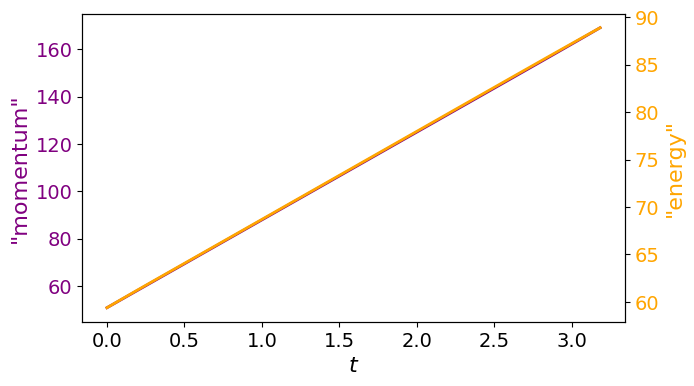

In [28]:
sol = sol6

# define how to sample the solution in time
tnum = 100
dt = (tmax-0)/tnum
tspan = np.linspace(0.,tmax,num=tnum)

# compute the momentum and energy as functions of t
momentum = np.empty(tnum)
energy = np.empty(tnum)
for it in range(0,tnum):
  uj = sol.sol(it*dt)
  momentum[it] = np.sum(uj)
  energy[it] = np.sum(0.5*uj**2)

# plot these quantities
fig, ax1 = plt.subplots(figsize=(7,4))

# momentum on the left axis
ax1.plot(tspan, momentum, lw=2, color='purple')
ax1.set_ylabel('"momentum"', color='purple')
ax1.set_xlabel('$t$')
ax1.tick_params(axis='y', labelcolor='purple')

# energy on the right axis
ax2 = ax1.twinx()
ax2.plot(tspan, energy, color='orange', lw=2)
ax2.set_ylabel('"energy"', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Space-time view of the dynamics

After running any one of the 4 examples above we can also try this...

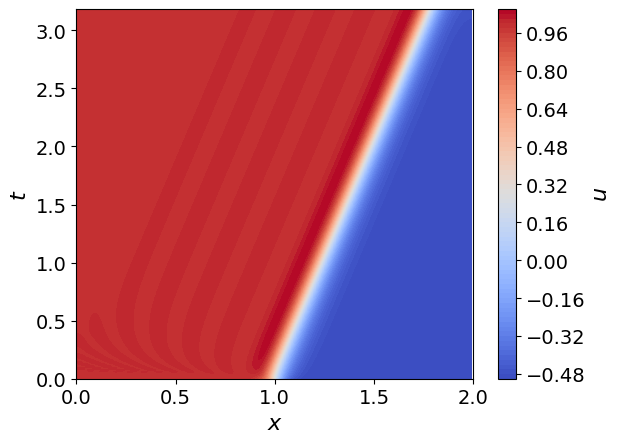

In [29]:
sol = sol6

# define how to sample the solution in time
tnum = N
dt = (tplot-0)/tnum
tspan = np.linspace(0.,tmax,num=tnum)

# make a matrix of space-time values u(x,t)
ujp = np.empty((tnum,N))
for it in range(0,tnum):
  ujp[it,:] = sol.sol(it*dt)

# make cool plot, try also cmap='RdGy'
fig, ax = plt.subplots()
plt.contourf(xj, tspan, ujp, 100, cmap='coolwarm')
plt.colorbar(label='$u$')
ax.set_ylim(0,tmax)
ax.set_ylabel('$t$')
ax.set_xlim(0,xmax)
ax.set_xlabel('$x$');
#ax.set_aspect(1/5)

# Ideas to explore on your own

A few ideas for interesting "computational experiments" to explore on your own are outlined here.

1.   Explore different initial conditions, beyond the suggested ones.
2.   Explore different boundary conditions and their implementation in the method of lines, for example as discussed in this [book chapter](https://link.springer.com/chapter/10.1007/978-3-319-06790-2_3).
3.   Try to implement an "upwind" scheme within the method of lines, for example as discussed in this [book chapter](https://link.springer.com/chapter/10.1007/978-3-319-06790-2_3).
4.   Try to add "artificial" diffusion to discretized inviscid Burgers equation to stabilize the scheme (when the solution becomes double-valued/discontinuous), for example as proposed in a classic paper of [Von Neumann \& Richtmyer](https://pubs.aip.org/aip/jap/article/21/3/232/159292/A-Method-for-the-Numerical-Calculation-of).
